### In this notebook, we will show how to configure GPy and gpytorch to give the same loss for a simple GP regression problem.

In [7]:
import numpy as np
import GPy
import gpytorch
import torch

# Generate the 1D regression dataset
np.random.seed(0)
N = 100
X = np.linspace(0, 1, N).reshape(-1, 1)
y = np.sin(2 * np.pi * X).ravel() + 0.05 * np.random.randn(N)

# Create the GPy model
kernel = GPy.kern.RBF(input_dim=1, lengthscale=1)
gpy_model = GPy.models.GPRegression(X, y.reshape(-1, 1), kernel)

# Evaluate the GPy loss
gpy_loss = -gpy_model.log_likelihood()

# Create the gpytorch model
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Set likelihood noise to the GPy value
likelihood.noise = gpy_model.likelihood.variance[0]

gpytorch_model = GPRegressionModel(torch.from_numpy(X).float(), torch.from_numpy(y).float(), likelihood)

# Set the kernel parameters to the GPy values
gpytorch_model.covar_module.base_kernel.lengthscale = gpy_model.kern.lengthscale[0]
gpytorch_model.covar_module.outputscale = gpy_model.kern.variance[0]

# Confirm that the GPy and gpytorch models have the same parameters
assert gpy_model.kern.lengthscale[0] == gpytorch_model.covar_module.base_kernel.lengthscale.item()
assert gpy_model.kern.variance[0] == gpytorch_model.covar_module.outputscale.item()
assert gpy_model.likelihood.variance[0] == gpytorch_model.likelihood.noise.item()

# Find the gpytorch loss
output = gpytorch_model(torch.from_numpy(X).float())
# MLL
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gpytorch_model)

# Find the gpytorch loss
gpytorch_loss = -mll(output, torch.from_numpy(y).float())

# Print the losses
print('GPy loss: {}'.format(gpy_loss))
# We multiply by N because the gpytorch loss is the average loss per data point
print('gpytorch loss: {}'.format(gpytorch_loss.item()*N))

GPy loss: 106.72974515800342
gpytorch loss: 106.72974586486816


In [10]:
# Now train both the GPy and gpytorch models and compare the losses and parameters
# Use multiple restarts to find the best GPy model
# Initialize the GPy model and then use the same hyperparameters in the gpytorch model
# Use same optimizer and training iterations for both models

# Train the GPy model with multiple restarts and 100 iterations
gpy_model.optimize(max_iters=100)

# Train the gpytorch model
gpytorch_model.train()
likelihood.train()

# Use the same optimizer as GPy
optimizer = torch.optim.LBFGS([
    {'params': gpytorch_model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# Create the closure for the LBFGS optimizer
def closure():
    optimizer.zero_grad()
    output = gpytorch_model(torch.from_numpy(X).float())
    loss = -mll(output, torch.from_numpy(y).float())
    loss.backward()
    return loss

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gpytorch_model)

training_iter = 100

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = gpytorch_model(torch.from_numpy(X).float())
    # Calc loss and backprop gradients
    loss = -mll(output, torch.from_numpy(y).float())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step(closure)
    

# Print the GPy and gpytorch losses

print('GPy loss: {}'.format(gpy_model.log_likelihood()))
print('gpytorch loss: {}'.format(-mll(output, torch.from_numpy(y).float()).item()))


Iter 1/100 - Loss: 1.067
Iter 2/100 - Loss: 3.263
Iter 3/100 - Loss: 1.079
Iter 4/100 - Loss: 1.076
Iter 5/100 - Loss: 1.076
Iter 6/100 - Loss: 1.076
Iter 7/100 - Loss: 1.076
Iter 8/100 - Loss: 1.076
Iter 9/100 - Loss: 1.076
Iter 10/100 - Loss: 1.076
Iter 11/100 - Loss: 1.076
Iter 12/100 - Loss: 1.076
Iter 13/100 - Loss: 1.076
Iter 14/100 - Loss: 1.076
Iter 15/100 - Loss: 1.076
Iter 16/100 - Loss: 1.076
Iter 17/100 - Loss: 1.076
Iter 18/100 - Loss: 1.076
Iter 19/100 - Loss: 1.076
Iter 20/100 - Loss: 1.076
Iter 21/100 - Loss: 1.076
Iter 22/100 - Loss: 1.076
Iter 23/100 - Loss: 1.076
Iter 24/100 - Loss: 1.076
Iter 25/100 - Loss: 1.076
Iter 26/100 - Loss: 1.076
Iter 27/100 - Loss: 1.076
Iter 28/100 - Loss: 1.076
Iter 29/100 - Loss: 1.076
Iter 30/100 - Loss: 1.076
Iter 31/100 - Loss: 1.076
Iter 32/100 - Loss: 1.076
Iter 33/100 - Loss: 1.076
Iter 34/100 - Loss: 1.076
Iter 35/100 - Loss: 1.076
Iter 36/100 - Loss: 1.076
Iter 37/100 - Loss: 1.076
Iter 38/100 - Loss: 1.076
Iter 39/100 - Loss: 1

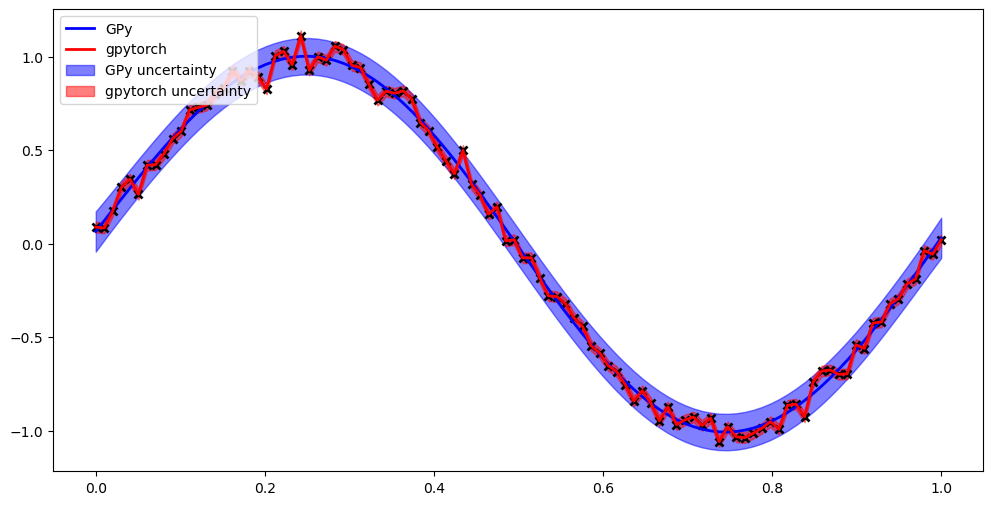

In [14]:
# plot the GPy and gpytorch models in the same plot

import matplotlib.pyplot as plt

# Get the GPy predictions
gpy_mean, gpy_var = gpy_model.predict(X)

# Get the gpytorch predictions
gpytorch_model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(gpytorch_model(torch.from_numpy(X).float()))

# Plot the GPy and gpytorch models
plt.figure(figsize=(12, 6))
plt.plot(X, y, 'kx', mew=2)
plt.plot(X, gpy_mean, 'b', lw=2, label='GPy')
plt.plot(X, observed_pred.mean.numpy(), 'r', lw=2, label='gpytorch')
plt.fill_between(X.flatten(), gpy_mean.flatten() - 2 * np.sqrt(gpy_var.flatten()), gpy_mean.flatten() + 2 * np.sqrt(gpy_var.flatten()), alpha=0.5, color='blue', label='GPy uncertainty')

# Get the lower and upper confidence bounds for the gpytorch model
lower, upper = observed_pred.confidence_region()
plt.fill_between(X.flatten(), lower.numpy().flatten(), upper.numpy().flatten(), alpha=0.5, color='red', label='gpytorch uncertainty')

plt.legend(loc='upper left')
